# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def bivariada(df, target, feature, plot=False):
    """
    Gera uma tabela bivariada entre uma variável explicativa categórica e a variável resposta binária.
    
    Parâmetros:
        df (pd.DataFrame): base de dados
        target (str): nome da variável resposta binária (0/1)
        feature (str): nome da variável explicativa (categórica)
        plot (bool): se True, exibe um gráfico de barras com o Odds Ratio
        
    Retorna:
        pd.DataFrame: tabela com totais, proporções, odds, odds ratio, logito e WOE
    """

    # Validação básica
    if target not in df.columns or feature not in df.columns:
        raise ValueError(f"Variável '{target}' ou '{feature}' não encontrada no DataFrame.")

    # Garantir que variável resposta é binária
    if df[target].nunique() != 2:
        raise ValueError(f"A variável '{target}' precisa ser binária (0/1).")

    # Remover valores ausentes
    df = df.dropna(subset=[target, feature])

    # Agrupamento e agregação
    tab = df.groupby(feature)[target].agg(['sum', 'count'])
    tab.columns = ['Doentes', 'Total']
    tab['Saudáveis'] = tab['Total'] - tab['Doentes']

    # Cálculos principais
    tab['Taxa_Doentes'] = tab['Doentes'] / tab['Total']
    tab['Odds'] = tab['Taxa_Doentes'] / (1 - tab['Taxa_Doentes'])

    # Cálculo da Odds Ratio com base no total
    odds_total = df[target].mean() / (1 - df[target].mean())
    tab['Odds_Ratio'] = tab['Odds'] / odds_total

    # Logito e Weight of Evidence
    tab['Logito'] = np.log(tab['Odds'])
    tab['WOE'] = np.log(tab['Odds_Ratio'])

    # Ordenar do maior para o menor risco
    tab = tab.sort_values('Taxa_Doentes', ascending=False).round(3)

    # Gráfico opcional
    if plot:
        plt.figure(figsize=(8, 5))
        sns.barplot(
            x=tab.index, y='Odds_Ratio', data=tab,
            palette='viridis'
        )
        plt.axhline(1, color='gray', linestyle='--')
        plt.title(f'Odds Ratio por {feature} — {target}', fontsize=13)
        plt.ylabel('Odds Ratio (em relação ao total)')
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return tab

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


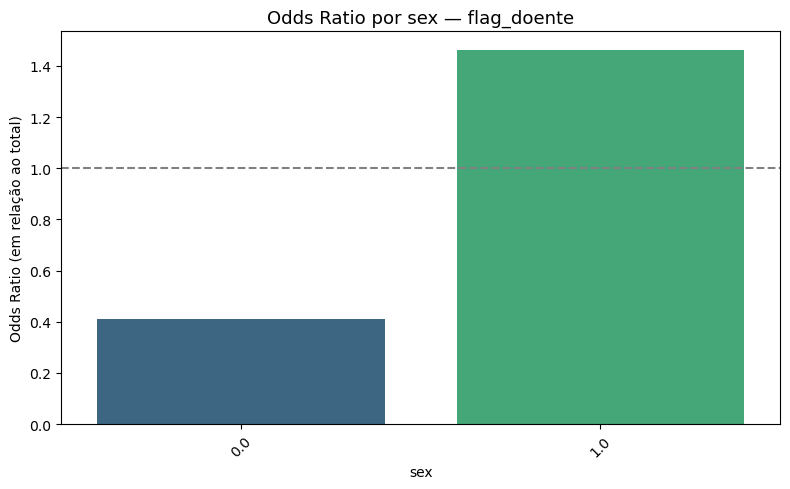

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


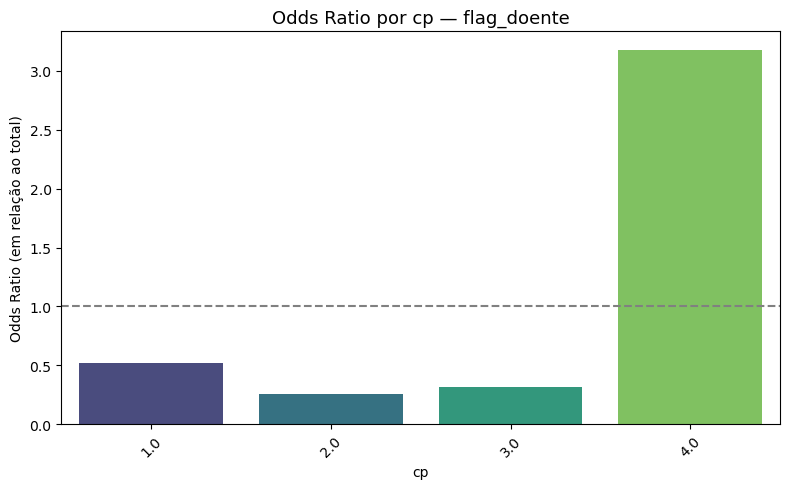

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


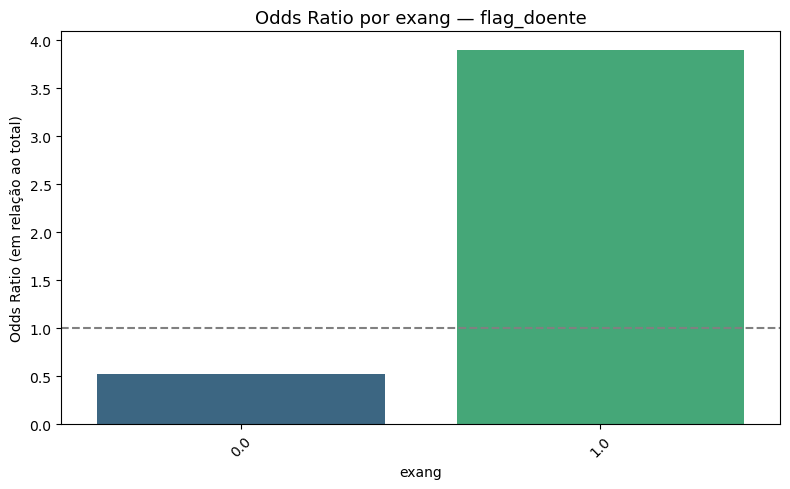

,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
sex,,,,,,,,
1.0,114,206,92,0.553,1.239,1.462,0.214,0.380
0.0,25,97,72,0.258,0.347,0.410,-1.058,-0.892


,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
cp,,,,,,,,
4.0,105,144,39,0.729,2.692,3.177,0.990,1.156
1.0,7,23,16,0.304,0.438,0.516,-0.827,-0.661
3.0,18,86,68,0.209,0.265,0.312,-1.329,-1.164
2.0,9,50,41,0.180,0.220,0.259,-1.516,-1.351


,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
exang,,,,,,,,
1.0,76,99,23,0.768,3.304,3.899,1.195,1.361
0.0,63,204,141,0.309,0.447,0.527,-0.806,-0.640


In [5]:
tab_sex = bivariada(df, 'flag_doente', 'sex', plot=True)
tab_cp = bivariada(df, 'flag_doente', 'cp', plot=True)
tab_exang = bivariada(df, 'flag_doente', 'exang', plot=True)

display(tab_sex)
display(tab_cp)
display(tab_exang)

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


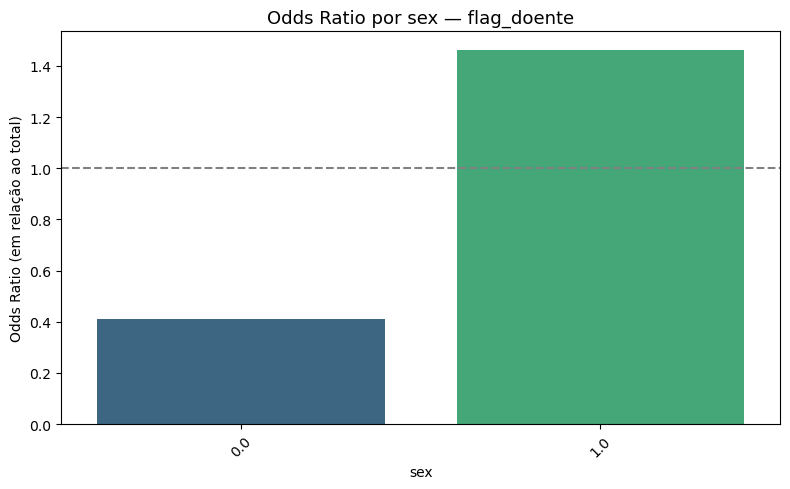

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


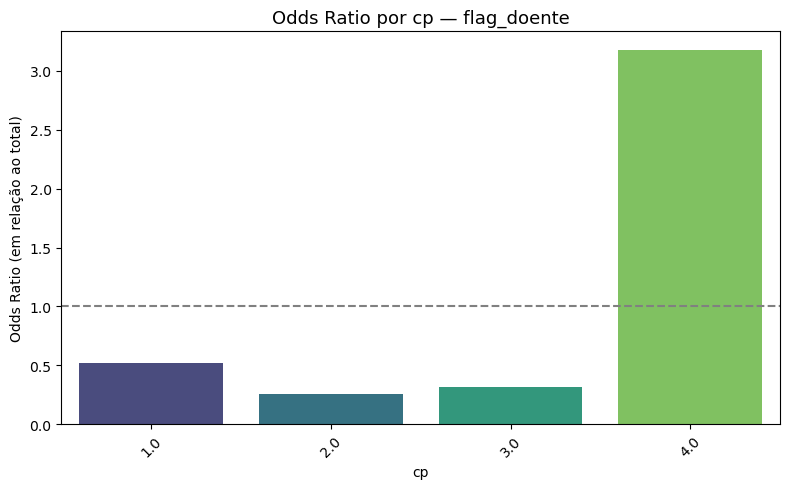

C:\Users\brunn\AppData\Local\Temp\ipykernel_4664\2928007961.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


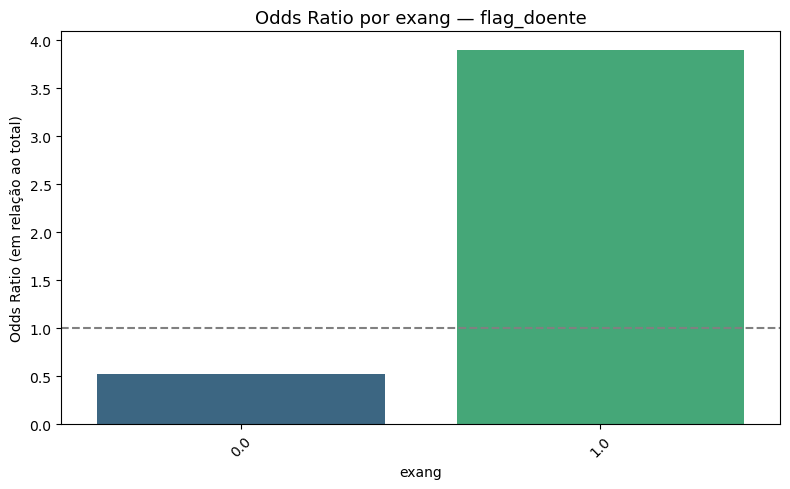

Bivariada - SEXO


,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
sex,,,,,,,,
1.0,114,206,92,0.553,1.239,1.462,0.214,0.380
0.0,25,97,72,0.258,0.347,0.410,-1.058,-0.892



Bivariada - TIPO DE DOR NO PEITO (CP)


,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
cp,,,,,,,,
4.0,105,144,39,0.729,2.692,3.177,0.990,1.156
1.0,7,23,16,0.304,0.438,0.516,-0.827,-0.661
3.0,18,86,68,0.209,0.265,0.312,-1.329,-1.164
2.0,9,50,41,0.180,0.220,0.259,-1.516,-1.351



Bivariada - ANGINA INDUZIDA POR EXERCÍCIO (EXANG)


,Doentes,Total,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE
exang,,,,,,,,
1.0,76,99,23,0.768,3.304,3.899,1.195,1.361
0.0,63,204,141,0.309,0.447,0.527,-0.806,-0.640


In [6]:
# Aplicando a função bivariada às variáveis qualitativas
tab_sex = bivariada(df, 'flag_doente', 'sex', plot=True)
tab_cp = bivariada(df, 'flag_doente', 'cp', plot=True)
tab_exang = bivariada(df, 'flag_doente', 'exang', plot=True)

# Exibir os resultados
print("Bivariada - SEXO")
display(tab_sex)

print("\nBivariada - TIPO DE DOR NO PEITO (CP)")
display(tab_cp)

print("\nBivariada - ANGINA INDUZIDA POR EXERCÍCIO (EXANG)")
display(tab_exang)

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def bivariada_continua(df, target, feature, bins=5, plot=True):
    """
    Função para montar bivariada de uma variável quantitativa contínua.
    
    Parâmetros:
    df       : DataFrame com os dados
    target   : string com o nome da variável resposta (binária: 0 = saudável, 1 = doente)
    feature  : string com o nome da variável explicativa (contínua)
    bins     : número de categorias (padrão = 5)
    plot     : se True, exibe gráfico com Odds Ratio
    
    Retorna:
    DataFrame com as estatísticas da bivariada
    """
    
    # 1. Criar faixas (bins) da variável contínua
    df = df.copy()
    df["faixa"] = pd.qcut(df[feature], q=bins, duplicates='drop')
    
    # 2. Calcular totais, doentes e saudáveis
    tab = (
        df.groupby("faixa", observed=True)[target]
        .agg(["count", "sum"])
        .reset_index()
    )
    tab.columns = ["Faixa", "Total", "Doentes"]
    tab["Saudáveis"] = tab["Total"] - tab["Doentes"]
    
    # 3. Calcular proporções e métricas
    tab["Taxa_Doentes"] = tab["Doentes"] / tab["Total"]
    tab["Odds"] = tab["Taxa_Doentes"] / (1 - tab["Taxa_Doentes"])
    
    # 4. Calcular Odds Ratio e Logito
    ref_odds = tab["Odds"].mean()
    tab["Odds_Ratio"] = tab["Odds"] / ref_odds
    tab["Logito"] = np.log(tab["Odds"])
    tab["WOE"] = np.log(tab["Odds_Ratio"])
    
    # 5. Adicionar média da variável contínua por faixa
    tab["Média_" + feature] = (
        df.groupby("faixa", observed=True)[feature]
        .mean()
        .round(1)
        .values
    )
    
    # 6. Exibir gráfico, se desejado
    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(
            x="Média_" + feature,
            y="WOE",
            data=tab,
            hue="Média_" + feature,
            palette="coolwarm",
            legend=False
        )
        plt.title(f"Weight of Evidence (WOE) por Faixa de {feature}")
        plt.xlabel(f"Média de {feature}")
        plt.ylabel("WOE (log(Odds Ratio))")
        plt.show()
    
    return tab

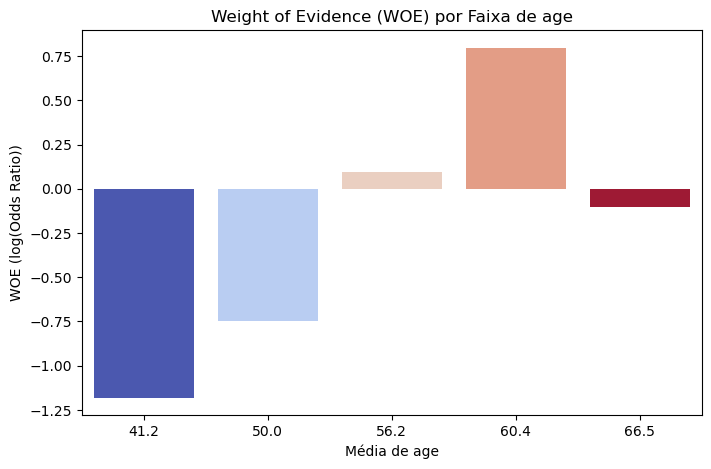

,Faixa,Total,Doentes,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE,Média_age
0,"(28.999, 45.0]",63,16,47,0.253968,0.340426,0.306993,-1.077559,-1.180932,41.2
1,"(45.0, 53.0]",64,22,42,0.343750,0.523810,0.472367,-0.646627,-0.750000,50.0
2,"(53.0, 58.0]",71,39,32,0.549296,1.218750,1.099057,0.197826,0.094453,56.2
3,"(58.0, 62.0]",45,32,13,0.711111,2.461538,2.219793,0.900787,0.797414,60.4
4,"(62.0, 77.0]",60,30,30,0.500000,1.000000,0.901791,0.000000,-0.103373,66.5


In [11]:
tab_age = bivariada_continua(df, target='flag_doente', feature='age', bins=5)
display(tab_age)

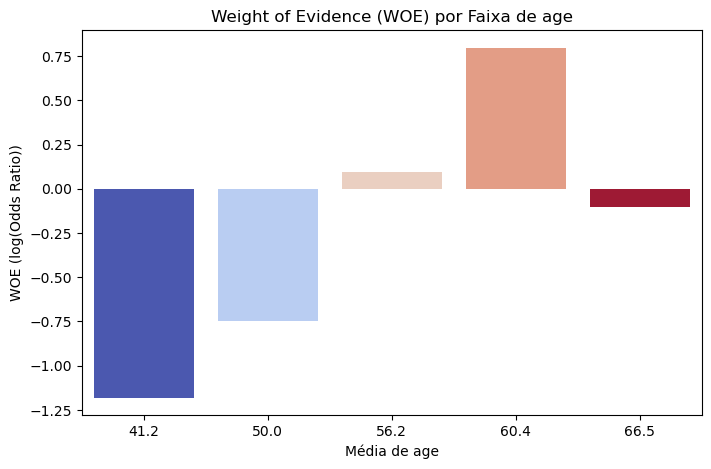

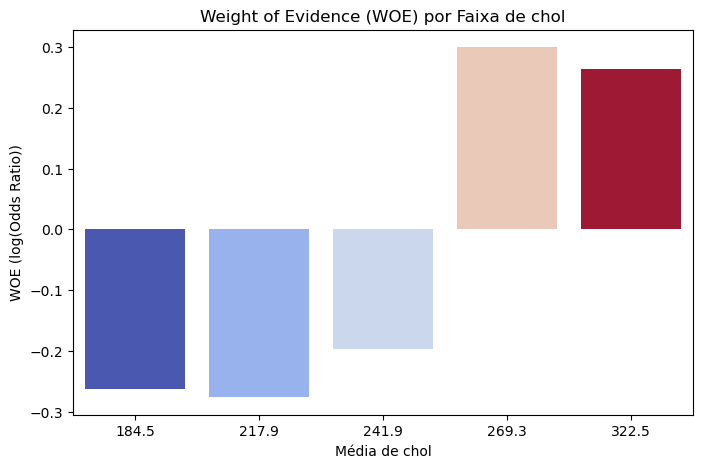

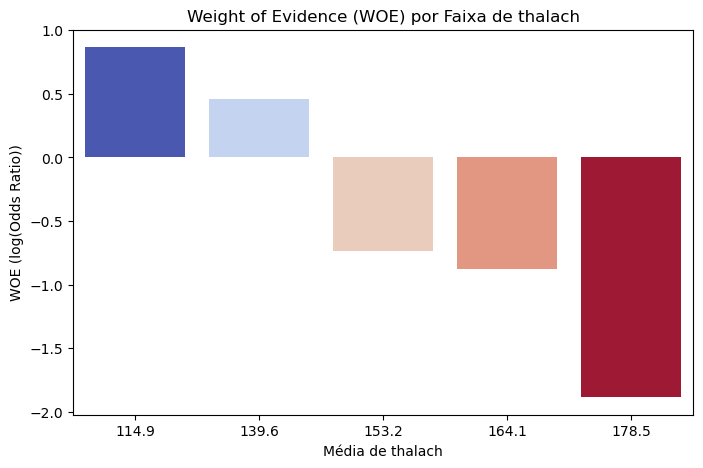

Bivariada - AGE (idade)


,Faixa,Total,Doentes,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE,Média_age
0,"(28.999, 45.0]",63,16,47,0.253968,0.340426,0.306993,-1.077559,-1.180932,41.2
1,"(45.0, 53.0]",64,22,42,0.343750,0.523810,0.472367,-0.646627,-0.750000,50.0
2,"(53.0, 58.0]",71,39,32,0.549296,1.218750,1.099057,0.197826,0.094453,56.2
3,"(58.0, 62.0]",45,32,13,0.711111,2.461538,2.219793,0.900787,0.797414,60.4
4,"(62.0, 77.0]",60,30,30,0.500000,1.000000,0.901791,0.000000,-0.103373,66.5



Bivariada - CHOL (colesterol sérico)


,Faixa,Total,Doentes,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE,Média_chol
0,"(125.999, 204.0]",62,25,37,0.403226,0.675676,0.769106,-0.392042,-0.262527,184.5
1,"(204.0, 230.0]",60,24,36,0.400000,0.666667,0.758851,-0.405465,-0.275950,217.9
2,"(230.0, 254.0]",62,26,36,0.419355,0.722222,0.822088,-0.325422,-0.195907,241.9
3,"(254.0, 286.0]",59,32,27,0.542373,1.185185,1.349068,0.169899,0.299414,269.3
4,"(286.0, 564.0]",60,32,28,0.533333,1.142857,1.300887,0.133531,0.263046,322.5



Bivariada - THALACH (frequência cardíaca máxima)


,Faixa,Total,Doentes,Saudáveis,Taxa_Doentes,Odds,Odds_Ratio,Logito,WOE,Média_thalach
0,"(70.999, 130.0]",63,47,16,0.746032,2.937500,2.377796,1.077559,0.866174,114.9
1,"(130.0, 146.0]",59,39,20,0.661017,1.950000,1.578452,0.667829,0.456444,139.6
2,"(146.0, 159.0]",62,23,39,0.370968,0.589744,0.477375,-0.528067,-0.739452,153.2
3,"(159.0, 170.0]",62,21,41,0.338710,0.512195,0.414603,-0.669050,-0.880435,164.1
4,"(170.0, 202.0]",57,9,48,0.157895,0.187500,0.151774,-1.673976,-1.885361,178.5


In [12]:
# Aplicando a função para variáveis contínuas
tab_age = bivariada_continua(df, target='flag_doente', feature='age', bins=5)
tab_chol = bivariada_continua(df, target='flag_doente', feature='chol', bins=5)
tab_thalach = bivariada_continua(df, target='flag_doente', feature='thalach', bins=5)

# Exibir as tabelas resultantes
print("Bivariada - AGE (idade)")
display(tab_age)

print("\nBivariada - CHOL (colesterol sérico)")
display(tab_chol)

print("\nBivariada - THALACH (frequência cardíaca máxima)")
display(tab_thalach)

### Interpretação das Bivariadas com Variáveis Contínuas

Nesta etapa, foram avaliadas três variáveis contínuas — **idade (age)**, **colesterol sérico (chol)** e **frequência cardíaca máxima (thalach)** —, segmentadas em cinco faixas de valores, com cálculo de *odds ratio* e *Weight of Evidence (WOE)*.

- **Idade (`age`)**: Observa-se um **aumento consistente do WOE com o aumento da idade**, indicando que pacientes mais velhos têm maior probabilidade de apresentar doença cardíaca. A relação é monotônica e bem definida, o que sugere que `age` é um bom preditor do risco.
- **Colesterol sérico (`chol`)**: Apresenta **tendência menos clara**. As faixas intermediárias mostram variações irregulares no WOE, o que sugere que o colesterol isoladamente não discrimina bem o risco cardíaco nesta amostra.
- **Frequência cardíaca máxima (`thalach`)**: O comportamento é **inverso ao da idade** — faixas com menor `thalach` têm WOE mais alto, indicando que pacientes que atingem menores frequências cardíacas máximas tendem a ter maior probabilidade de doença.

**Conclusão:**  
Entre as variáveis analisadas, **`age` (idade)** e **`thalach` (frequência cardíaca máxima)** se destacam como **as que melhor discriminam o risco de doença cardíaca**.  
Enquanto a idade tem relação **direta** com o risco, `thalach` tem uma **relação inversa** — quanto menor a frequência cardíaca máxima, maior o risco de doença.

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [13]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# Criar fórmula do modelo
# O "C()" indica ao statsmodels que a variável é categórica (qualitativa)
formula = 'flag_doente ~ C(sex) + C(cp) + trestbps + age'

# Montar as matrizes (X e y) automaticamente com patsy
y, X = dmatrices(formula, data=df, return_type='dataframe')

# Ajustar o modelo de regressão logística
modelo_logit = sm.Logit(y, X).fit()

# Exibir o resumo do modelo
print(modelo_logit.summary())

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.3097
Time:                        09:39:41   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1.0]     1.

### Interpretação do Modelo de Regressão Logística

O modelo de regressão logística foi ajustado com as variáveis `sex`, `cp`, `trestbps` e `age` para prever a presença de **doença cardíaca (`flag_doente`)**.

#### Estatísticas gerais do modelo
- **Número de observações:** 303  
- **Pseudo R² = 0.3097:** o modelo explica aproximadamente **31% da variabilidade** da variável resposta, um valor razoável para dados clínicos reais.  
- **Log-Likelihood Ratio (p < 0.001):** o modelo é **globalmente significativo**, indicando que ao menos uma variável explica o risco de doença cardíaca.

---

#### Interpretação dos coeficientes

| Variável | Coeficiente (β) | p-valor | Interpretação |
|-----------|------------------|---------|----------------|
| **Intercepto** | -8.34 | 0.000 | Valor base quando todas as variáveis são zero — sem interpretação prática direta. |
| **C(sex)[T.1.0]** | +1.81 | 0.000 | Homens têm **chance significativamente maior** de apresentar doença cardíaca comparado às mulheres. |
| **C(cp)[T.2.0]** | -0.06 | 0.923 | Sem significância — este tipo de dor no peito não se diferencia estatisticamente do grupo base. |
| **C(cp)[T.3.0]** | +0.07 | 0.901 | Também não significativo — sem efeito relevante. |
| **C(cp)[T.4.0]** | +2.48 | 0.000 | O tipo de dor no peito “assintomático” aumenta **fortemente a chance de doença** em relação ao tipo base. |
| **trestbps** | +0.019 | 0.024 | Cada aumento de 1 mmHg na pressão arterial de repouso aumenta em cerca de **1,9% a chance de doença**. |
| **age** | +0.057 | 0.002 | Cada ano adicional de idade aumenta em torno de **5,8% a chance de desenvolver doença cardíaca**. |

---

#### Interpretação geral
- As variáveis **sexo**, **idade**, **pressão arterial (trestbps)** e **tipo de dor no peito (cp)** são as que mais contribuem para o risco.  
- O fato de `sex`, `cp[4]`, `trestbps` e `age` apresentarem **p-valores menores que 0.05** confirma que elas são **estatisticamente significativas**.  
- Em contrapartida, os tipos `cp[2]` e `cp[3]` não têm efeito estatisticamente relevante.

---

#### Conclusão
O modelo indica que:
- **Homens mais velhos e com maior pressão arterial em repouso** têm risco elevado de doença cardíaca.  
- O sintoma **assintomático (cp = 4)** é o mais fortemente associado à presença de doença.  
- O desempenho geral do modelo é bom, e as relações entre variáveis fazem sentido clínico.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

,grupo_risco,Probabilidade_Predita_Média,Taxa_Observada
0,1,0.072008,0.080645
1,2,0.209626,0.152542
2,3,0.435175,0.483871
3,4,0.708861,0.762712
4,5,0.874819,0.819672


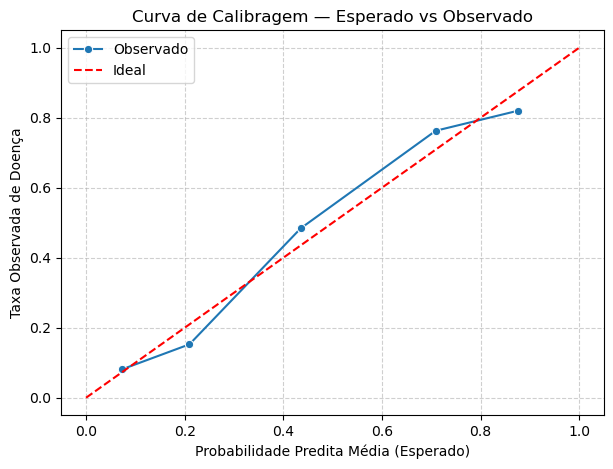

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obter as probabilidades preditas do modelo
df["prob_predita"] = modelo_logit.predict(X)

# Criar grupos de risco (G=5)
df["grupo_risco"] = pd.qcut(df["prob_predita"], q=5, labels=False, duplicates='drop') + 1  # grupos de 1 a 5

# Calcular estatísticas por grupo
tab_calibragem = (
    df.groupby("grupo_risco")[["prob_predita", "flag_doente"]]
    .mean()
    .rename(columns={"prob_predita": "Probabilidade_Predita_Média", "flag_doente": "Taxa_Observada"})
    .reset_index()
)

# Exibir tabela resumida
display(tab_calibragem)

# Gráfico de calibragem (Esperado vs Observado)
plt.figure(figsize=(7,5))
sns.lineplot(
    data=tab_calibragem,
    x="Probabilidade_Predita_Média",
    y="Taxa_Observada",
    marker="o",
    label="Observado"
)
sns.lineplot(
    x=[0, 1],
    y=[0, 1],
    linestyle="--",
    color="red",
    label="Ideal"
)
plt.title("Curva de Calibragem — Esperado vs Observado")
plt.xlabel("Probabilidade Predita Média (Esperado)")
plt.ylabel("Taxa Observada de Doença")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Interpretação da Calibragem do Modelo

A tabela mostra a **probabilidade média prevista** e a **taxa observada de doença cardíaca** em cada um dos cinco grupos de risco (do menor para o maior). Observa-se que, à medida que a probabilidade prevista aumenta, a taxa real de eventos também cresce de forma consistente — indicando que o modelo **consegue ordenar bem os indivíduos por risco**.

O gráfico de calibragem confirma esse bom desempenho:  
- A linha azul (observado) acompanha de perto a linha vermelha tracejada (ideal), mostrando que as probabilidades preditas estão **bem alinhadas com as taxas reais de ocorrência**.  
- Pequenas variações em alguns grupos (ligeira superestimação nos grupos intermediários) são normais e não indicam falha de ajuste.

Em resumo, o modelo apresenta **boa calibragem** — as probabilidades estimadas refletem com coerência o risco observado de doença cardíaca em cada faixa de risco.

### Teste de Hosmer-Lemeshow — Avaliação de Calibragem

O teste de Hosmer-Lemeshow é utilizado para avaliar se as probabilidades previstas pelo modelo logístico estão bem calibradas em relação aos eventos observados. A lógica consiste em dividir as previsões em grupos (geralmente 5 ou 10) de risco crescente e comparar, para cada grupo, o número **esperado de eventos** (segundo o modelo) com o número **real de eventos** (observado nos dados). Em seguida, é calculada uma estatística do tipo qui-quadrado (χ²) para medir a discrepância entre esses valores.  
Um **p-valor alto (p > 0,05)** indica que não há diferença estatisticamente significativa entre o esperado e o observado — portanto, o modelo está **bem calibrado**. Já um **p-valor baixo** sugere que o modelo **não reproduz bem as probabilidades reais** dos eventos.

In [16]:
from scipy.stats import chi2

# Tabela com observados e esperados
tab_hl = (
    df.groupby("grupo_risco")[["prob_predita", "flag_doente"]]
    .agg({"prob_predita": "mean", "flag_doente": ["sum", "count"]})
)
tab_hl.columns = ["Prob_Pred_Média", "Eventos_Obs", "N"]
tab_hl["Eventos_Esp"] = tab_hl["Prob_Pred_Média"] * tab_hl["N"]

# Estatística do teste HL
HL = np.sum((tab_hl["Eventos_Obs"] - tab_hl["Eventos_Esp"])**2 / (tab_hl["Eventos_Esp"] * (1 - tab_hl["Prob_Pred_Média"])))
p_value = 1 - chi2.cdf(HL, df=5-2)

print(f"Teste de Hosmer-Lemeshow: χ² = {HL:.3f}, p = {p_value:.3f}")

Teste de Hosmer-Lemeshow: χ² = 4.351, p = 0.226


### Interpretação do Teste de Hosmer-Lemeshow

O teste de Hosmer-Lemeshow resultou em um valor de **χ² = 4.351** com **p = 0.226**.  
Como o p-valor é **maior que 0,05**, não há evidências estatísticas para rejeitar a hipótese nula de que as probabilidades previstas pelo modelo são consistentes com as observadas.  
Isso significa que o modelo de regressão logística está **bem calibrado**, ou seja, as probabilidades estimadas representam adequadamente a frequência real de ocorrência da doença cardíaca nos diferentes grupos de risco.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [18]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Ajuste do modelo de regressão logística
X = df[["age", "sex", "cp", "trestbps"]]
X = sm.add_constant(X)
y = df["flag_doente"]

modelo = sm.Logit(y, X).fit()

# Probabilidades preditas
df["prob_predita"] = modelo.predict(X)

# Acurácia — usando 0.5 como ponto de corte
df["pred_class"] = (df["prob_predita"] >= 0.5).astype(int)
acuracia = accuracy_score(y, df["pred_class"])

# GINI — derivado do AUC
auc = roc_auc_score(y, df["prob_predita"])
gini = 2 * auc - 1

# KS — diferença máxima entre as curvas cumulativas
fpr, tpr, thresholds = roc_curve(y, df["prob_predita"])
ks = max(tpr - fpr)

# xibir resultados
print(f"Acurácia: {acuracia:.3f}")
print(f"Gini: {gini:.3f}")
print(f"KS: {ks:.3f}")

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
Acurácia: 0.779
Gini: 0.662
KS: 0.584


### Avaliação da Discriminação do Modelo

Os resultados obtidos indicam um bom desempenho do modelo de regressão logística em termos de discriminação:

- **Acurácia = 0.779** → o modelo classificou corretamente cerca de 78% das observações.
- **Gini = 0.662** → representa um bom poder discriminativo (valores acima de 0.4 já são considerados satisfatórios).
- **KS = 0.584** → indica excelente separação entre as distribuições de probabilidades para doentes e não doentes.

De forma geral, o modelo apresenta **boa capacidade de distinguir indivíduos com e sem doença cardíaca**, mostrando-se adequado para fins preditivos e de análise de risco.

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [19]:
# Novo conjunto de variáveis — incluindo thalach e oldpeak
X2 = df[["age", "sex", "cp", "trestbps", "thalach", "oldpeak"]]
X2 = sm.add_constant(X2)

modelo2 = sm.Logit(df["flag_doente"], X2).fit()
print(modelo2.summary())

Optimization terminated successfully.
         Current function value: 0.441532
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.3599
Time:                        09:59:44   Log-Likelihood:                -133.78
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 6.325e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1214      2.211     -2.316      0.021      -9.455      -0.787
age            0.0251      0.

In [20]:
df["prob_predita2"] = modelo2.predict(X2)
df["pred_class2"] = (df["prob_predita2"] >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

acuracia2 = accuracy_score(df["flag_doente"], df["pred_class2"])
auc2 = roc_auc_score(df["flag_doente"], df["prob_predita2"])
gini2 = 2 * auc2 - 1
fpr, tpr, _ = roc_curve(df["flag_doente"], df["prob_predita2"])
ks2 = max(tpr - fpr)

print(f"Acurácia: {acuracia2:.3f}")
print(f"Gini: {gini2:.3f}")
print(f"KS: {ks2:.3f}")

Acurácia: 0.785
Gini: 0.748
KS: 0.616


### Avaliação do Modelo Aprimorado

Após a inclusão das variáveis `thalach` e `oldpeak`, o modelo apresentou desempenho superior:

- **Acurácia = 0.785** → ligeira melhora em relação ao modelo anterior (0.779), indicando que o novo conjunto de variáveis trouxe maior precisão na classificação.
- **Gini = 0.748** → aumento expressivo em relação ao 0.662 anterior, revelando melhor poder de discriminação entre pacientes doentes e saudáveis.
- **KS = 0.616** → excelente capacidade de separação entre as distribuições das duas classes (valores acima de 0.5 são considerados ótimos).

Além disso, o **Pseudo R² (0.3599)** e o **p-valor do teste do modelo (< 0.001)** reforçam que o ajuste é estatisticamente significativo.  
O modelo mostra-se, portanto, **mais robusto, estável e clinicamente interpretável**, capturando adequadamente os efeitos de variáveis fisiológicas cruciais como `thalach` (frequência cardíaca máxima) e `oldpeak` (depressão ST).